# Generate Data

In [25]:
import numpy as np
import math
from doubleml.datasets import make_plr_CCDDHNR2018, make_plr_turrell2018
np.random.seed(1234)
n_rep = 100
n_obs = 10000
n_vars = 10
alpha = 0.5
data = list()
from sklearn.datasets import make_spd_matrix

def g(x):
    return np.exp(x)

def m(x):
    return np.sin(x)

theta = alpha = 0.5 
b = [1/k for k in range(1,n_vars+1)] # x weights 
sigma = make_spd_matrix(n_vars, random_state=42)

for i_rep in range(n_rep):
    #(x, y, d) = make_plr_turrell2018(alpha=alpha, n_obs=n_obs, dim_x=n_vars, return_type='array')
    x = np.random.multivariate_normal(np.ones(n_vars),sigma,size=[n_obs,])
    G = g(np.dot(x,b))
    M = m(np.dot(x,b))
    d = M+np.random.standard_normal(size=[n_obs,])
    y = np.dot(alpha,d)+G+np.random.standard_normal(size=[n_obs,])
    data.append((x, y, d))

# Naive ML
- no orthogonalisation, no crossfitting

In [26]:
def non_orth_score(y, d, l_hat, m_hat, g_hat, smpls):
    u_hat = y - g_hat
    psi_a = -np.multiply(d, d)
    psi_b = np.multiply(d, u_hat)
    return psi_a, psi_b

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


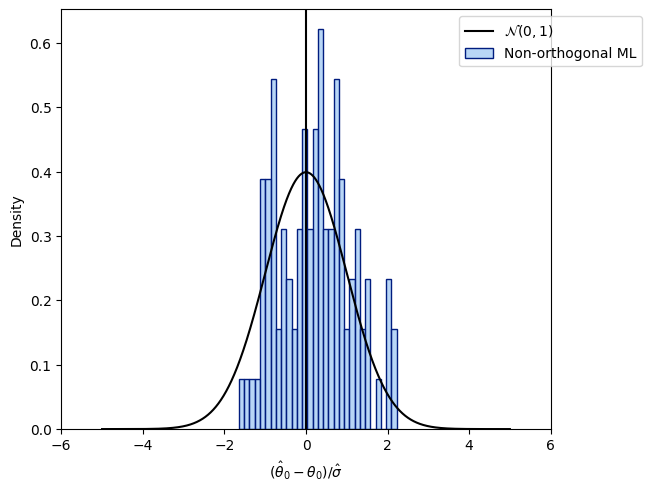

In [27]:
from doubleml import DoubleMLData
from doubleml import DoubleMLPLR
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import clone
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
face_colors = sns.color_palette('pastel')
edge_colors = sns.color_palette('dark')
np.random.seed(1111)
ml_l = RandomForestRegressor(n_estimators=132, max_features=12, max_depth=5, min_samples_leaf=1)
ml_m = RandomForestRegressor(n_estimators=378, max_features=20, max_depth=3, min_samples_leaf=6)
ml_g = clone(ml_l)

# to speed up the illustration we hard-code the simulation results
theta_nonorth = np.empty(n_rep)
se_nonorth = np.empty(n_rep)
# to run the full simulation uncomment the following line to fit the model for every dataset and not just for the first dataset
for i_rep in range(n_rep):
    print(i_rep)
#for i_rep in range(1):
    (x, y, d) = data[i_rep]
    obj_dml_data = DoubleMLData.from_arrays(x, y, d)
    obj_dml_plr_nonorth = DoubleMLPLR(obj_dml_data,
                                      ml_l, ml_m, ml_g,
                                      n_folds=2,
                                      apply_cross_fitting=False,
                                      score=non_orth_score)
    obj_dml_plr_nonorth.fit()
    this_theta = obj_dml_plr_nonorth.coef[0]
    this_se = obj_dml_plr_nonorth.se[0]
    theta_nonorth[i_rep] = obj_dml_plr_nonorth.coef[0]
    se_nonorth[i_rep] = obj_dml_plr_nonorth.se[0]

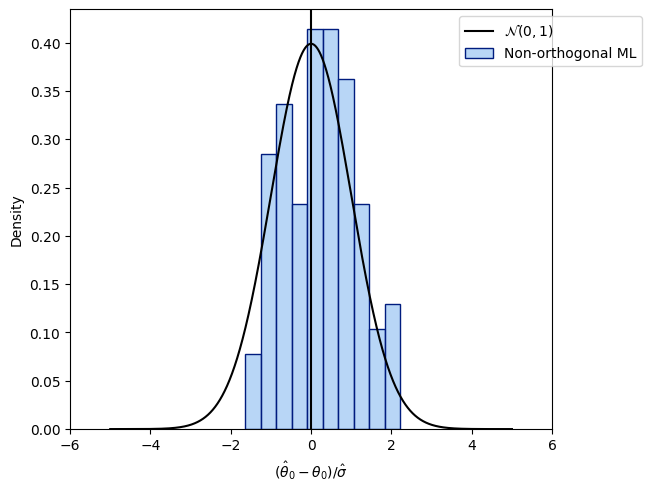

In [58]:
plt.figure(constrained_layout=True);
ax = sns.histplot((theta_nonorth - alpha)/se_nonorth,
                  color=face_colors[0], edgecolor = edge_colors[0],
                  stat='density', bins=10, label='Non-orthogonal ML');
ax.axvline(0., color='k');
xx = np.arange(-5, +5, 0.001)
yy = stats.norm.pdf(xx)
ax.plot(xx, yy, color='k', label='$\\mathcal{N}(0, 1)$');
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0));
ax.set_xlim([-6., 6.]);
ax.set_xlabel('$(\hat{\\theta}_0 - \\theta_0)/\hat{\sigma}$');
plt.savefig('ex1-1.png')

# Orthogonal Machine Learning
- resolves regularization bias, but not overfitting

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


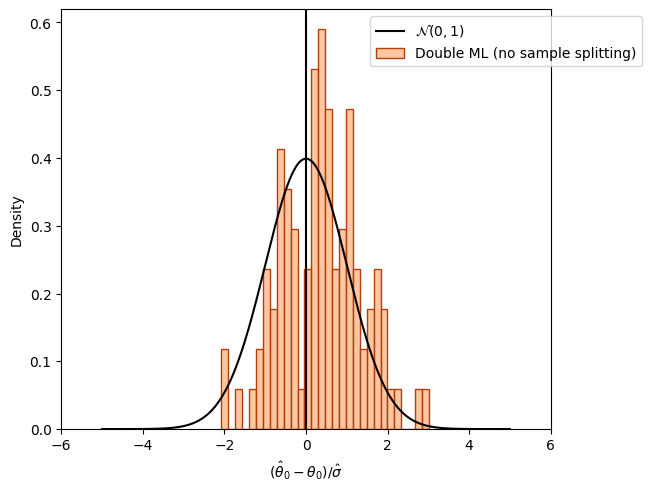

In [28]:
import numpy as np
np.random.seed(2222)
# to speed up the illustration we hard-code the simulation results
theta_orth_nosplit = np.empty(n_rep)
se_orth_nosplit = np.empty(n_rep)
# to run the full simulation uncomment the following line to fit the model for every dataset and not just for the first dataset
for i_rep in range(n_rep):
    print(i_rep)
#for i_rep in range(1):
    (x, y, d) = data[i_rep]
    obj_dml_data = DoubleMLData.from_arrays(x, y, d)
    obj_dml_plr_orth_nosplit = DoubleMLPLR(obj_dml_data,
                                           ml_l, ml_m, ml_g,
                                           n_folds=1,
                                           score='IV-type',
                                           apply_cross_fitting=False)
    obj_dml_plr_orth_nosplit.fit()
    theta_orth_nosplit[i_rep] = obj_dml_plr_orth_nosplit.coef[0]
    se_orth_nosplit[i_rep] = obj_dml_plr_orth_nosplit.se[0]

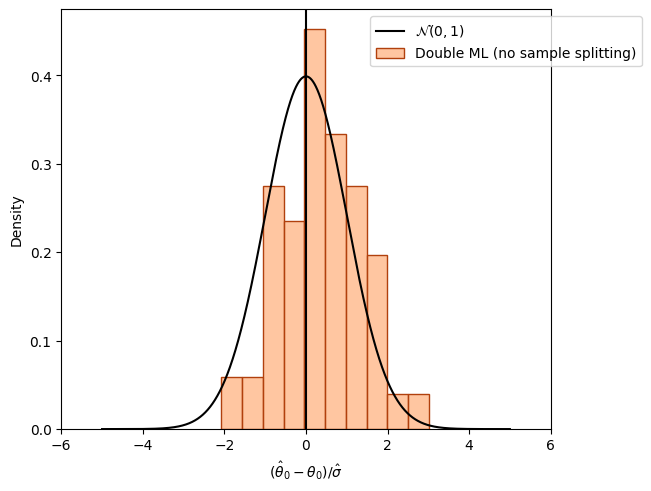

In [59]:
plt.figure(constrained_layout=True);
ax = sns.histplot((theta_orth_nosplit - alpha)/se_orth_nosplit,
                  color=face_colors[1], edgecolor = edge_colors[1],
                  stat='density', bins=10, label='Double ML (no sample splitting)');
ax.axvline(0., color='k');
xx = np.arange(-5, +5, 0.001)
yy = stats.norm.pdf(xx)
ax.plot(xx, yy, color='k', label='$\\mathcal{N}(0, 1)$');
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0));
ax.set_xlim([-6., 6.]);
ax.set_xlabel('$(\hat{\\theta}_0 - \\theta_0)/\hat{\sigma}$');
plt.savefig('ex1-2.png')

# Orthogonal ML + Cross fitting (DML)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


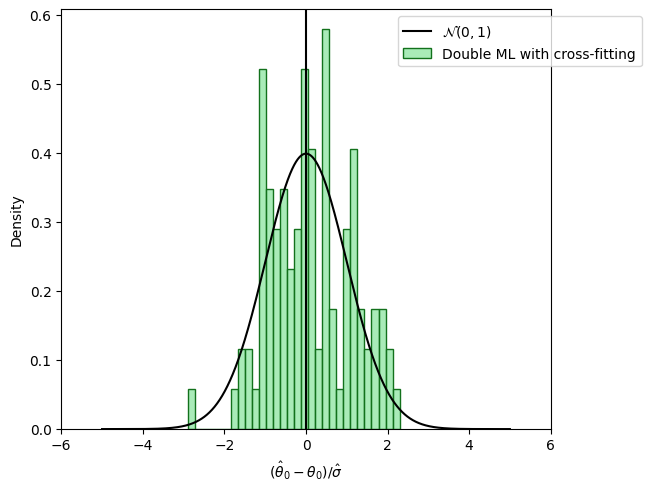

In [29]:
np.random.seed(42)
# to speed up the illustration we hard-code the simulation results
theta_dml = np.empty(n_rep)
se_dml = np.empty(n_rep)

# to run the full simulation uncomment the following line to fit the model for every dataset and not just for the first dataset
for i_rep in range(n_rep):
    print(i_rep)
    (x, y, d) = data[i_rep]
    obj_dml_data = DoubleMLData.from_arrays(x, y, d)
    obj_dml_plr = DoubleMLPLR(obj_dml_data,
                              ml_l, ml_m, ml_g,
                              n_folds=2,
                              score='IV-type')
    obj_dml_plr.fit()
    theta_dml[i_rep] = obj_dml_plr.coef[0]
    se_dml[i_rep] = obj_dml_plr.se[0]

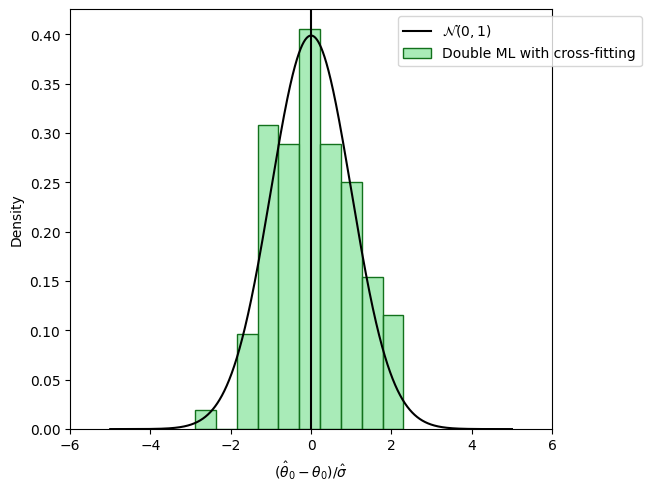

In [60]:
plt.figure(constrained_layout=True);
ax = sns.histplot((theta_dml - alpha)/se_dml,
                  color=face_colors[2], edgecolor = edge_colors[2],
                  stat='density', bins=10, label='Double ML with cross-fitting');
ax.axvline(0., color='k');
xx = np.arange(-5, +5, 0.001)
yy = stats.norm.pdf(xx)
ax.plot(xx, yy, color='k', label='$\\mathcal{N}(0, 1)$');
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0));
ax.set_xlim([-6., 6.]);
ax.set_xlabel('$(\hat{\\theta}_0 - \\theta_0)/\hat{\sigma}$');
plt.savefig('ex1-3.png')

# Regular OLS

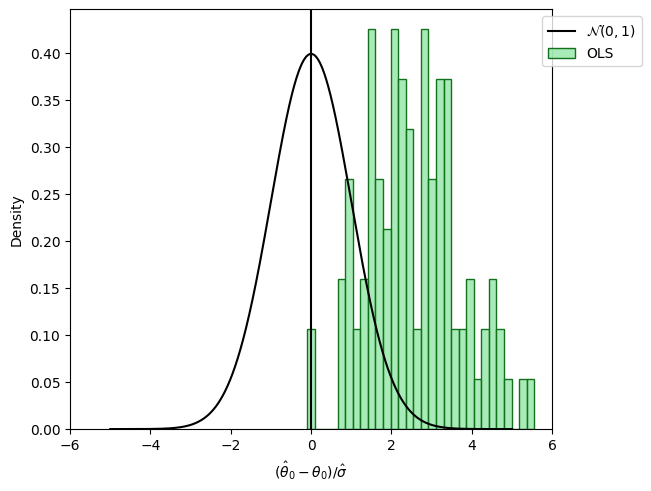

In [30]:
np.random.seed(42)
import statsmodels.api as sm # for OLS 
# to speed up the illustration we hard-code the simulation results
theta_ols = np.empty(n_rep)
se_ols = np.empty(n_rep)
# to run the full simulation uncomment the following line to fit the model for every dataset and not just for the first dataset
for i_rep in range(n_rep):
    (x, y, d) = data[i_rep]
    OLS = sm.OLS(y,sm.add_constant(np.c_[d,x]))
    results = OLS.fit()
    theta_ols[i_rep] = results.params[1]
    se_ols[i_rep] = results.bse[1]   

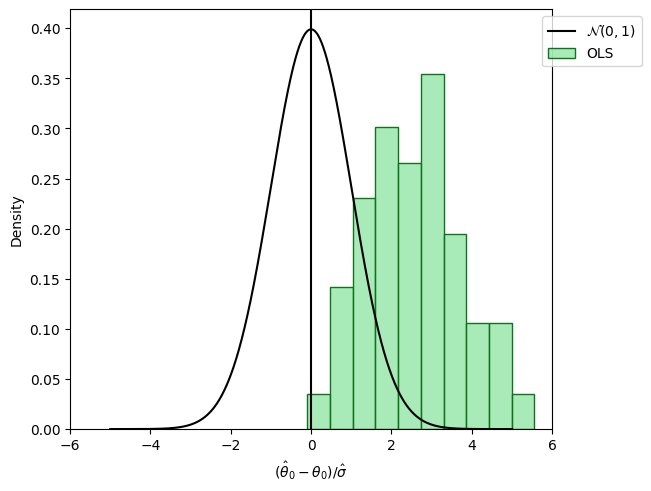

In [61]:
plt.figure(constrained_layout=True);
ax = sns.histplot((theta_ols - alpha)/se_ols,
                  color=face_colors[2], edgecolor = edge_colors[2],
                  stat='density', bins=10, label='OLS');
ax.axvline(0., color='k');
xx = np.arange(-5, +5, 0.001)
yy = stats.norm.pdf(xx)
ax.plot(xx, yy, color='k', label='$\\mathcal{N}(0, 1)$');
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0));
ax.set_xlim([-6., 6.]);
ax.set_xlabel('$(\hat{\\theta}_0 - \\theta_0)/\hat{\sigma}$');
plt.savefig('ex1-4.png')

# Distribution of Theta

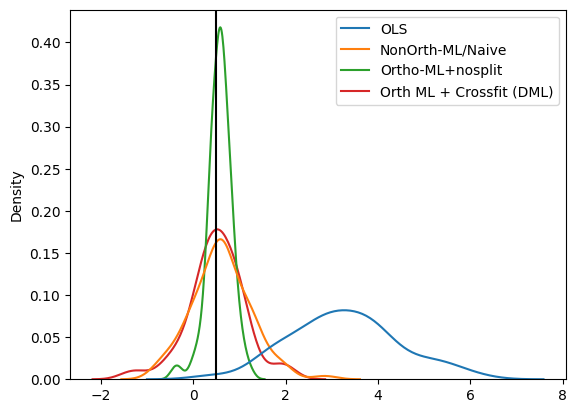

In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
MC_θ = np.c_[theta_ols, theta_nonorth, theta_orth_nosplit, theta_dml]

df = pd.DataFrame(MC_θ,columns=['OLS','NonOrth-ML/Naive','Ortho-ML+nosplit','Orth ML + Crossfit (DML)'])
sns.kdeplot(df)
plt.axvline(0.5, color='black')
plt.savefig('ex1-5.png')

In [63]:
from prettytable import PrettyTable
from PIL import Image, ImageDraw, ImageFont
MC_θ = np.c_[theta_ols, theta_nonorth, theta_orth_nosplit, theta_dml]
table = PrettyTable()
table.field_names = ['Var', 'OLS','NaiveML','OrthoML','DML']
a = ['Mean θ_hat']+ np.mean(MC_θ, axis = 0).tolist()
table.add_row(a)
a = ['Stdev θ_hat']+ np.std(MC_θ, axis = 0).tolist()
table.add_row(a)
a = ['97.5 Quantile θ_hat']+ np.quantile(MC_θ,0.975, axis = 0).tolist()
table.add_row(a)
a = ['2.5 Quantile θ_hat']+ np.quantile(MC_θ,0.025, axis = 0).tolist()
table.add_row(a)
table.float_format = '0.3'
print(table)

+---------------------+-------+---------+---------+--------+
|         Var         |  OLS  | NaiveML | OrthoML |  DML   |
+---------------------+-------+---------+---------+--------+
|      Mean θ_hat     | 3.273 |  0.615  |  0.572  | 0.512  |
|     Stdev θ_hat     | 1.168 |  0.635  |  0.260  | 0.616  |
| 97.5 Quantile θ_hat | 5.612 |  1.894  |  1.049  | 1.908  |
|  2.5 Quantile θ_hat | 1.368 |  -0.598 |  0.005  | -0.868 |
+---------------------+-------+---------+---------+--------+


# First Stage Checks

In [43]:
OLS = sm.OLS(y,sm.add_constant(np.c_[d, x]))
results = OLS.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     255.9
Date:                Sun, 11 Dec 2022   Prob (F-statistic):               0.00
Time:                        15:30:15   Log-Likelihood:                -29552.
No. Observations:                5000   AIC:                         5.913e+04
Df Residuals:                    4988   BIC:                         5.921e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -95.1871     16.347     -5.823      0.000    -127.234     -63.141
x1             2.9358      1.267      2.317      0.021       0.452       5.420
x2            45.6688      2.334     19.565      0.000      41.093      50.245
x3            28.4858      2.135     13.344      0.000      24.301      32.671
x4            10.3584      3.726      2.780      0.005       3.054      17.663
x5             8.9618      3.394      2.640      0.008       2.308      15.616
x6            15.3325      2.785      5.505      0.000       9.872      20.793
x7            11.6568      2.555      4.562      0.000       6.647      16.666
x8             7.4969      2.614      2.868      0.004       2.372      12.622
x9             8.1002      2.713      2.986      0.003       2.782      13.419
x10            0.8084      2.728      0.296      0.767      -4.539       6.156
x11            6.2883      1.640      3.833      0.000       3.072       9.504
==============================================================================
Omnibus:                     8919.675   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         13509652.031
Skew:                          12.695   Prob(JB):                         0.00
Kurtosis:                     256.381   Cond. No.                         51.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
OLS = sm.OLS(d,sm.add_constant(np.c_[x]))
results = OLS.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.011
Date:                Sun, 11 Dec 2022   Prob (F-statistic):              0.431
Time:                        15:30:03   Log-Likelihood:                -7081.7
No. Observations:                5000   AIC:                         1.419e+04
Df Residuals:                    4989   BIC:                         1.426e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0070      0.183     -0.039      0.969      -0.365       0.351
x1             0.0136      0.026      0.523      0.601      -0.037       0.065
x2             0.0123      0.024      0.517      0.605      -0.034       0.059
x3             0.0256      0.042      0.614      0.539      -0.056       0.107
x4             0.0439      0.038      1.158      0.247      -0.030       0.118
x5             0.0426      0.031      1.369      0.171      -0.018       0.104
x6            -0.0075      0.029     -0.263      0.792      -0.063       0.048
x7            -0.0218      0.029     -0.746      0.455      -0.079       0.035
x8             0.0054      0.030      0.179      0.858      -0.054       0.065
x9             0.0030      0.030      0.099      0.921      -0.057       0.063
x10            0.0052      0.018      0.284      0.776      -0.031       0.041
==============================================================================
Omnibus:                        1.172   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.556   Jarque-Bera (JB):                1.215
Skew:                          -0.032   Prob(JB):                        0.545
Kurtosis:                       2.957   Cond. No.                         51.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
np.std(theta_ols), np.std(theta_dml)

(0.047310123843566865, 0.04759238952472454)

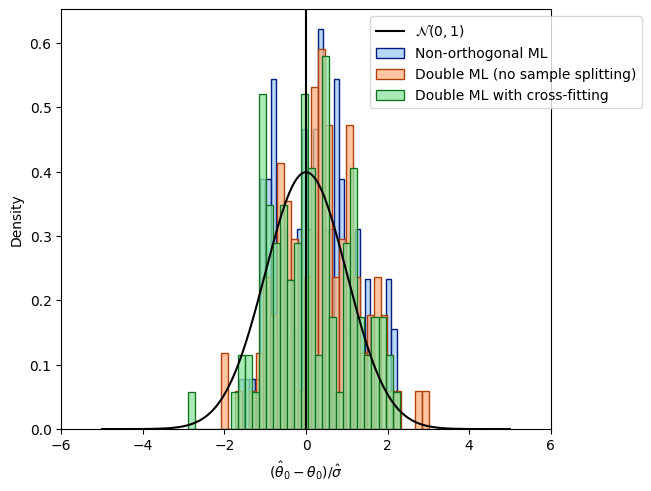

In [34]:
plt.figure(constrained_layout=True);

ax = sns.histplot((theta_nonorth - alpha)/se_nonorth,
                  color=face_colors[0], edgecolor = edge_colors[0],
                  stat='density', bins=30, label='Non-orthogonal ML');

sns.histplot((theta_orth_nosplit - alpha)/se_orth_nosplit,
             color=face_colors[1], edgecolor = edge_colors[1],
             stat='density', bins=30, label='Double ML (no sample splitting)');

sns.histplot((theta_dml - alpha)/se_dml,
             color=face_colors[2], edgecolor = edge_colors[2],
             stat='density', bins=30, label='Double ML with cross-fitting');


ax.axvline(0., color='k');

xx = np.arange(-5, +5, 0.001)

yy = stats.norm.pdf(xx)

ax.plot(xx, yy, color='k', label='$\\mathcal{N}(0, 1)$');

ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0));

ax.set_xlim([-6., 6.]);

ax.set_xlabel('$(\hat{\\theta}_0 - \\theta_0)/\hat{\sigma}$');